## Introduction

There are many tools investors use to both discover and analyze different potential investments. One popular tool for discovery & analysis is the stock screener. This tool helps investors narrow down potential investments based on their own criteria. The criteria filter could be placed on anything from how fast the company grows sales to one specific industry the investor wants to analyze. 

The problem with the stock screener is that companies are grouped in a rule based way. What if we could instead, group potential investments algorithmically, allowing companies to cluster naturally with one another based on their individual characteristics? **To solve this problem, we will be using a popular unsupervised learning algorithm known as a K-Means to build an investment tool integrated with Power BI to help investors speed up their investment process and identify overlooked opportunities in the market relative to their true peer group.**

To do this, we will be scraping hundreds of stock tickers, along with their financials and valuations from Yahoo Finance using BeautifulSoup. Then, we will use the raw data given by each company's financials to produce relevant metrics. This feature engineering process will require us to build in YOY growth rates & composition ratios (Ex: What % of sales is Research & Development), valuation ratios, and profitability ratios. 

The growth rates & composition ratios will be used to cluster our companies into different groups. They can tell us whether a company is in its growth phase, whether it is capital intensive to run, or if the company relies more on its intangible assets (Ex: Patents, Brand, Intellectual Property). The valuation & profitability ratios we create will then be built into our Power BI tool. These additional ratios can help investors decide how they want to sort each of the clusters and where they may be opportunities suited to their own investment style. Let's get started.

In [1]:
#import packages

import re
import json
import csv
from io import StringIO
from bs4 import BeautifulSoup
import requests
import pandas as pd

We'll start by reading a list of over 600 stock tickers, many of which are in the S&P 500 index. Some of the other companies are European and/or companies that I follow closely. This list of stocks can be interchanged with other stocks that can be retrieved from Yahoo Finance.

In [2]:
#read list of stock tickers

holdings = pd.read_csv('ticker_list.csv')

In [3]:
#convert to list

holdings = holdings['TICKER'].tolist()

To scrape the financials we need, we will use the base url below. We need the income statement, balance sheet, and cash flow statement for each company.

In [4]:
url_financials = 'https://finance.yahoo.com/quote/{}/financials?p={}'

Let's first build a for loop that iterates through our stock tickers. To start, we'll need to use the requests library and assign the response from each ticker's associated webpage to a response variable. Then, we will use BeautifulSoup to parse the html. In the html, we can find json formatted strings with the information most relevant to us. To get this information though, we need to get the script tag using regular expressions, extract the contents from it, and then leave *only* the json formatted strings which we can convert into a dictionary.

This resource was very helpful to me when scraping these financials: [How to Scrape Stocks and Financials from Yahoo Finance](https://www.youtube.com/watch?v=fw4gK-leExw&list=WL&index=32&t=379s)

In [5]:
#create three empty lists
#iterate through range of tickers
#request webpage for each ticker
#parse html and pattern match using regex
#find script match
#find the word context
#pull inc stmt, bal sheet, and cf
#pull ticker from each and append to respective lists

inc = []
bs = []
cf = []

for i in range(len(holdings)):
    try:
        response = requests.get(url_financials.format(holdings[i], holdings[i]))
        soup = BeautifulSoup(response.text, 'html.parser')
        pattern = re.compile(r'\s--\sData\s--\s')
        script_data = soup.find('script', text = pattern).contents[0]
        start = script_data.find('context')-2
        json_data = json.loads(script_data[start:-12])
        annual_is = json_data['context']['dispatcher']['stores']['QuoteSummaryStore']['incomeStatementHistory']['incomeStatementHistory']
        annual_bs = json_data['context']['dispatcher']['stores']['QuoteSummaryStore']['cashflowStatementHistory']['cashflowStatements']
        annual_cf = json_data['context']['dispatcher']['stores']['QuoteSummaryStore']['balanceSheetHistory']['balanceSheetStatements']
        annual_is[0]['ticker'] = {'raw': holdings[i]}
        annual_bs[0]['ticker'] = {'raw': holdings[i]}
        annual_cf[0]['ticker'] = {'raw': holdings[i]}
        inc.append(annual_is)
        bs.append(annual_bs)
        cf.append(annual_cf)
    except Exception:
        pass

The output of this code leaves us with many dictionaries inside many dictionaries, all within one list for each statement. This is because each value on the financial statements have a raw format, an abbreviated format, and a normal format within a dictionary for a single line item. We want the raw format from each line item, so we need to build a separate loop that pulls *only* these values into a list for each financial statement.

In [9]:
#initialize empty list
#loop through list and initialize empty dict
#pull raw formatted numbers
#append to dict

annual_is_stmnt = []

for is_ in inc:
    for i in is_:
        statement = {}
        for key, val in i.items():
            try:
                statement[key] = val['raw']
            except TypeError:
                continue
            except KeyError:
                continue
        annual_is_stmnt.append(statement)

In [10]:
#apply same loop

annual_bal_stmnt = []

for bs_ in bs:
    for i in bs_:
        statement = {}
        for key, val in i.items():
            try:
                statement[key] = val['raw']
            except TypeError:
                continue
            except KeyError:
                continue
        annual_bal_stmnt.append(statement)

In [11]:
#apply same loop

annual_cf_stmnt = []

for cf_ in cf:
    for i in cf_:
        statement = {}
        for key, val in i.items():
            try:
                statement[key] = val['raw']
            except TypeError:
                continue
            except KeyError:
                continue
        annual_cf_stmnt.append(statement)

In [18]:
#preview
pd.DataFrame(annual_is_stmnt).head()

,incomeBeforeTax,minorityInterest,netIncome,sellingGeneralAdministrative,grossProfit,ebit,endDate,operatingIncome,otherOperatingExpenses,interestExpense,incomeTaxExpense,totalRevenue,totalOperatingExpenses,costOfRevenue,totalOtherIncomeExpenseNet,netIncomeFromContinuingOps,netIncomeApplicableToCommonShares,ticker,researchDevelopment,discontinuedOperations
0,1164400000,5700000.0,928300000,1.679600e+09,5141100000,1599900000,1601164800,1599900000,430300000.0,-437000000.0,239700000,23518000000,21918100000,18376900000,-435500000,924700000,928300000,SBUX,NaN,NaN
1,4466200000,1200000.0,3599200000,1.824100e+09,7488100000,3915700000,1569715200,3915700000,371000000.0,-331000000.0,871600000,26508600000,22592900000,19020500000,550500000,3594600000,3599200000,NaN,NaN,NaN
2,5780000000,6300000.0,4518300000,1.704600e+09,7316600000,3810100000,1538265600,3810100000,554900000.0,-170300000.0,1262000000,24719500000,20909400000,17402900000,1969900000,4518000000,4518300000,NaN,NaN,NaN
3,4317500000,6900000.0,2884700000,1.408400e+09,6834600000,3896800000,1506816000,3896800000,518000000.0,-92500000.0,1432600000,22386800000,18490000000,15552200000,420700000,2884900000,2884700000,NaN,NaN,NaN
4,1118000000,NaN,1002000000,8.640000e+08,2501000000,1028000000,1577577600,1028000000,NaN,-52000000.0,128000000,3543000000,2515000000,1042000000,90000000,990000000,1002000000,ILMN,575000000.0,NaN


We now have four years of financial information for each stock ticker. We will later remove companies that don't meet this threshold. As shown in the dataframe above, the tickers we pulled are only applied to the most recent year. Notice the null values under SBUX. Luckily, fixing this is simple, since we can just forward fill each ticker.

In [19]:
#forward fill stock tickers

inc = pd.DataFrame(annual_is_stmnt)
inc['ticker'] = inc['ticker'].fillna(method = 'ffill')

In [20]:
bal = pd.DataFrame(annual_bal_stmnt)
bal['ticker'] = bal['ticker'].fillna(method = 'ffill')

In [21]:
cf = pd.DataFrame(annual_cf_stmnt)
cf['ticker'] = cf['ticker'].fillna(method = 'ffill')

We also need each row to be identifiable by their calendar year. One way we can do this is to add a cumulative count for each row (meaning 4 years of financials will be labeled 1-4) and then replace the numbers 1-4 with the most recent year (using the datetime package) all the way to the first year we have on record. Let's do that for each financial statement.

In [22]:
#cumulatively count ticker appearances
#replace numbers with year descending

from datetime import datetime

inc['count'] = 1
inc['year'] = inc.groupby('ticker')['count'].cumsum()
last_fs = datetime.now().year - 1
inc['year'] = inc['year'].replace(to_replace = {1: last_fs, 2: last_fs - 1, 3: last_fs - 2, 4: last_fs - 3})

In [23]:
bal['count'] = 1
bal['year'] = bal.groupby('ticker')['count'].cumsum()
last_fs = datetime.now().year - 1
bal['year'] = bal['year'].replace(to_replace = {1: last_fs, 2: last_fs - 1, 3: last_fs - 2, 4: last_fs - 3})

In [24]:
cf['count'] = 1
cf['year'] = cf.groupby('ticker')['count'].cumsum()
last_fs = datetime.now().year - 1
cf['year'] = cf['year'].replace(to_replace = {1: last_fs, 2: last_fs - 1, 3: last_fs - 2, 4: last_fs - 3})

In [25]:
inc.head()

,incomeBeforeTax,minorityInterest,netIncome,sellingGeneralAdministrative,grossProfit,ebit,endDate,operatingIncome,otherOperatingExpenses,interestExpense,...,totalOperatingExpenses,costOfRevenue,totalOtherIncomeExpenseNet,netIncomeFromContinuingOps,netIncomeApplicableToCommonShares,ticker,researchDevelopment,discontinuedOperations,count,year
0,1164400000,5700000.0,928300000,1.679600e+09,5141100000,1599900000,1601164800,1599900000,430300000.0,-437000000.0,...,21918100000,18376900000,-435500000,924700000,928300000,SBUX,NaN,NaN,1,2020
1,4466200000,1200000.0,3599200000,1.824100e+09,7488100000,3915700000,1569715200,3915700000,371000000.0,-331000000.0,...,22592900000,19020500000,550500000,3594600000,3599200000,SBUX,NaN,NaN,1,2019
2,5780000000,6300000.0,4518300000,1.704600e+09,7316600000,3810100000,1538265600,3810100000,554900000.0,-170300000.0,...,20909400000,17402900000,1969900000,4518000000,4518300000,SBUX,NaN,NaN,1,2018
3,4317500000,6900000.0,2884700000,1.408400e+09,6834600000,3896800000,1506816000,3896800000,518000000.0,-92500000.0,...,18490000000,15552200000,420700000,2884900000,2884700000,SBUX,NaN,NaN,1,2017
4,1118000000,NaN,1002000000,8.640000e+08,2501000000,1028000000,1577577600,1028000000,NaN,-52000000.0,...,2515000000,1042000000,90000000,990000000,1002000000,ILMN,575000000.0,NaN,1,2020


With each row having a ticker and year, we can now merge these statements into one complete financial statement that will be our primary data set used for analysis.

In [26]:
#merge inc, bal, cf, onto single financial statment

stmt = pd.merge(inc, bal, on = ['ticker', 'year'], suffixes = ('_inc', '_bal'))
stmt = pd.merge(stmt, cf, on = ['ticker', 'year'], suffixes = ('', '_cf'))

In [27]:
#save

stmt.to_pickle('Projects/fin_stmt.pkl')

Before we move onto feature engineering, we'll need the valuations of each company. Having a real time view into how a company is valued by the market is crucial to making sound decisions using any investment tool. To pull this information, we can follow the same basic format as above. In this case, we will pull the Price to Sales Ratio (PS). Sales is one useful way to value a company. Using this multiple, we can get at the total valuation of the company, also known as Market Capitalization. To do this, we simply would need to multiply total revenue, which we can get from the income statement, with the sales multiple we will be scraping below. Once we get the market cap, we can use it to derive many other valuation multiples, a few of which we'll be using later.

In using the loop this time, we need to pull different json strings (summary detail, symbol) and store them separately. Then we'll pull the raw formatted numbers again and then join the two data sets together so that each revenue multiple has a ticker associated with it.

In [28]:
#intialize empty lists
#pull valuation info into detail var
#pull ticker name as unique identifier
#append to respective lists

val = []
tick = []

for i in range(len(holdings)):
    try:
        response = requests.get(url_financials.format(holdings[i], holdings[i]))
        soup = BeautifulSoup(response.text, 'html.parser')
        pattern = re.compile(r'\s--\sData\s--\s')
        script_data = soup.find('script', text = pattern).contents[0]
        start = script_data.find('context')-2
        json_data = json.loads(script_data[start:-12])
        detail = json_data['context']['dispatcher']['stores']['QuoteSummaryStore']['summaryDetail']
        ticker = json_data['context']['dispatcher']['stores']['QuoteSummaryStore']['symbol']
        val.append(detail)
        tick.append(ticker)
    except Exception:
        pass

In [29]:
#pull only raw formatted numbers

mkt = []

for i in val:
    statement = {}
    for key, val in i.items():
        try:
            statement[key] = val['raw']
        except TypeError:
            continue
        except KeyError:
            continue
    mkt.append(statement)

In [30]:
#check for lists to match in length

print(len(mkt))
print(len(tick))

619
619


In [31]:
#join directly

tick = pd.DataFrame(tick, columns = ['ticker'])
mkt = pd.DataFrame(mkt).join(tick)

We can call the joined data set PS and store it separately. Right now each ticker has a trailing twelve month Price to Sales ratio. The information we pulled above from each financial statement is over 4 years. So before we join the two data sets, we must collapse the financial statement information down to a single row first (since we want each row to represent one company), which we will do in our next section. For the time being, we will hold onto the PS data set and remember to join it onto our primary data set later.

In [32]:
#filter to non null values
#rename column

PS = mkt[mkt['priceToSalesTrailing12Months'] >= 0][['ticker', 'priceToSalesTrailing12Months']]
PS.rename(columns = {'priceToSalesTrailing12Months': 'PS'}, inplace = True)

In [33]:
PS.to_pickle('Projects/ps.pkl')

### Feature Engineering

We can now start the process of turning the raw data we collected into something more useful. In this section, we will be creating a variety of common investment metrics used in industry by investors, as well as a few new ones to help us analyze more unconventional businesses.

In [1]:
#import packages

import pandas as pd
import numpy as np

stmt = pd.read_pickle('Projects/fin_stmt.pkl')

In [2]:
stmt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2406 entries, 0 to 2405
Data columns (total 75 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   incomeBeforeTax                        2406 non-null   int64  
 1   minorityInterest                       1235 non-null   float64
 2   netIncome_inc                          2406 non-null   int64  
 3   sellingGeneralAdministrative           2354 non-null   float64
 4   grossProfit                            2406 non-null   int64  
 5   ebit                                   2406 non-null   int64  
 6   endDate_inc                            2406 non-null   int64  
 7   operatingIncome                        2406 non-null   int64  
 8   otherOperatingExpenses                 944 non-null    float64
 9   interestExpense                        2138 non-null   float64
 10  incomeTaxExpense                       2406 non-null   int64  
 11  tota

To create the profitability/liquidity ratios we want, we'll only need some of the columns listed above. So let's use the next steps to consolidate the data set and then change the numbers to be in thousands for readability.

In [6]:
#keep select columns
#filter to companies with sales

stmt = stmt[['researchDevelopment', 'netIncome_inc', 'sellingGeneralAdministrative', 'grossProfit', 'ebit', 
             'operatingIncome', 'interestExpense', 'totalRevenue', 'ticker', 'year', 'capitalExpenditures', 
             'totalStockholderEquity', 'cash', 'longTermDebt', 'totalCashFromOperatingActivities', 
             'retainedEarnings', 'incomeTaxExpense', 'shortLongTermDebt', 'depreciation', 'totalCurrentAssets',
            'totalCurrentLiabilities', 'netReceivables', 'shortTermInvestments']]

stmt = stmt[stmt['totalRevenue'] > 0]

In [7]:
stmt['year'] = stmt['year'].astype('object')
num = stmt.select_dtypes(include = ['float', 'integer']).columns

In [8]:
#divide numbers by 1000

stmt[num] = stmt[num]/1000

In [9]:
#keep only tickers with 4 yrs operating history
stmt = stmt.groupby('ticker').filter(lambda x: len(x) == 4)

stmt.head()

,researchDevelopment,netIncome_inc,sellingGeneralAdministrative,grossProfit,ebit,operatingIncome,interestExpense,totalRevenue,ticker,year,...,longTermDebt,totalCashFromOperatingActivities,retainedEarnings,incomeTaxExpense,shortLongTermDebt,depreciation,totalCurrentAssets,totalCurrentLiabilities,netReceivables,shortTermInvestments
0,NaN,928.3,1679.6,5141.1,1599.9,1599.9,-437.0,23518.0,SBUX,2020,...,14728.9,1597.8,-7815.6,239.7,1249.9,1503.2,7806.4,7346.8,1395.4,281.2
1,NaN,3599.2,1824.1,7488.1,3915.7,3915.7,-331.0,26508.6,SBUX,2019,...,11169.6,5047.0,-5771.2,871.6,NaN,1449.3,5653.9,6168.7,1020.3,70.5
2,NaN,4518.3,1704.6,7316.6,3810.1,3810.1,-170.3,24719.5,SBUX,2018,...,9122.7,11937.8,1457.4,1262.0,349.9,1305.9,12494.2,5684.2,1648.5,181.5
3,NaN,2884.7,1408.4,6834.6,3896.8,3896.8,-92.5,22386.8,SBUX,2017,...,3932.6,4251.8,5563.2,1432.6,NaN,1067.1,5283.4,4220.7,938.4,228.6
4,575.0,1002.0,864.0,2501.0,1028.0,1028.0,-52.0,3543.0,ILMN,2020,...,1141.0,1051.0,4067.0,128.0,NaN,188.0,4451.0,665.0,573.0,1372.0


Below is a list of feature engineered columns using our raw data. These are very common financial ratios to help us evaluate businesses. The features with a % in the title are composition ratios that we will use for clustering later on. These can tell us how a business spends its money as a portion of its sales. The other features (ROA, Turnover, ROE, ROIC) listed below are profitabilty ratios often used by value investors. They can give us indication of how well a business is using its capital to generate profits. This however, is not applicable to all companies. Some companies are still in its growth stage, where these metrics don't yet apply since they may not be prioritizing profitability at their stage. We will use different metrics to help us better quantify the quality of those companies.

In [10]:
#profitability/composition ratios

stmt['GM%'] = stmt['grossProfit']/stmt['totalRevenue']
stmt['R&D%'] = stmt['researchDevelopment']/stmt['totalRevenue']
stmt['G&A%'] = stmt['sellingGeneralAdministrative']/stmt['totalRevenue']
stmt['Op%'] = stmt['operatingIncome']/stmt['totalRevenue']
stmt['ROA'] = stmt['netIncome_inc']/stmt['totalCurrentAssets']
stmt['ROE'] = stmt['netIncome_inc']/stmt['totalStockholderEquity']
stmt['ROIC'] = stmt['ebit']/(stmt['longTermDebt'] + stmt['totalStockholderEquity'] - stmt['cash'])
stmt['Turnover'] = stmt['totalRevenue']/(stmt['longTermDebt'] + stmt['totalStockholderEquity'] - stmt['cash'])
stmt['FCF'] = stmt['totalCashFromOperatingActivities'] + stmt['capitalExpenditures']
stmt['CapEx%'] = (stmt['capitalExpenditures']/stmt['totalRevenue'])*-1
stmt['FCF%'] = stmt['FCF']/stmt['totalRevenue']

The Current Ratio (CR), Quick Ratio (QR), and Debt to Equity Ratio (D/E) are measures commonly used by investors to assess a company's liquidity. We've calculated all three measures below to be used in our Power BI tool.

In [11]:
#liquidity ratios

stmt['D/E'] = (stmt['longTermDebt'] + stmt['shortLongTermDebt'])/stmt['totalStockholderEquity']
stmt['CR'] = stmt['totalCurrentAssets']/stmt['totalCurrentLiabilities']
stmt['QR'] = (stmt['cash'] + stmt['netReceivables'] + stmt['shortTermInvestments'])/stmt['totalCurrentLiabilities']

In [12]:
stmt.loc[:, stmt.isnull().any()].head()

,researchDevelopment,sellingGeneralAdministrative,interestExpense,capitalExpenditures,totalStockholderEquity,cash,longTermDebt,totalCashFromOperatingActivities,retainedEarnings,shortLongTermDebt,...,ROA,ROE,ROIC,Turnover,FCF,CapEx%,FCF%,D/E,CR,QR
0,NaN,1679.6,-437.0,-1483.6,-7805.1,4350.9,14728.9,1597.8,-7815.6,1249.9,...,0.118915,-0.118935,0.621828,9.140658,114.2,0.063084,0.004856,-2.047226,1.062558,0.820425
1,NaN,1824.1,-331.0,-1806.6,-6232.2,2686.6,11169.6,5047.0,-5771.2,NaN,...,0.636587,-0.577517,1.739693,11.777412,3240.4,0.068151,0.122240,NaN,0.916546,0.612349
2,NaN,1704.6,-170.3,-1976.4,1169.5,8756.3,9122.7,11937.8,1457.4,349.9,...,0.361632,3.863446,2.480695,16.094472,9961.4,0.079953,0.402977,8.099701,2.198058,1.862408
3,NaN,1408.4,-92.5,-1519.4,5450.1,2462.3,3932.6,4251.8,5563.2,NaN,...,0.545993,0.529293,0.563089,3.234900,2732.4,0.067870,0.122054,NaN,1.251783,0.859881
4,575.0,864.0,-52.0,-209.0,4613.0,2042.0,1141.0,1051.0,4067.0,NaN,...,0.225118,0.217212,0.276940,0.954472,842.0,0.058990,0.237652,NaN,6.693233,5.995489


Many of the null values in our data set are related to companies not spending at all on R&D or carrying no debt. We can fix this by filling in the nulls with zeroes. We also want to specify the most recent year. Then, we can filter out all years before that and join them separately back onto the data set as prior years. This will help us consolidate the data set so that each company has a single row with which we can use to tack on YOY growth rates.

In [13]:
stmt = stmt.fillna(0)
stmt['last_yr'] = stmt['year'].max()

In [14]:
#create prior year data set

py = stmt[stmt['last_yr'] - stmt['year'] > 0].reset_index(drop = True)

In [15]:
py = py[stmt.columns]

Below is the data set with all years prior to the most recent. We can join each of these years separately back onto the original data frame.

In [16]:
py.head()

,researchDevelopment,netIncome_inc,sellingGeneralAdministrative,grossProfit,ebit,operatingIncome,interestExpense,totalRevenue,ticker,year,...,ROE,ROIC,Turnover,FCF,CapEx%,FCF%,D/E,CR,QR,last_yr
0,0.0,3599.2,1824.1,7488.1,3915.7,3915.7,-331.0,26508.6,SBUX,2019,...,-0.577517,1.739693,11.777412,3240.4,0.068151,0.122240,0.000000,0.916546,0.612349,2020
1,0.0,4518.3,1704.6,7316.6,3810.1,3810.1,-170.3,24719.5,SBUX,2018,...,3.863446,2.480695,16.094472,9961.4,0.079953,0.402977,8.099701,2.198058,1.862408,2020
2,0.0,2884.7,1408.4,6834.6,3896.8,3896.8,-92.5,22386.8,SBUX,2017,...,0.529293,0.563089,3.234900,2732.4,0.067870,0.122054,0.000000,1.251783,0.859881,2020
3,568.0,826.0,849.0,2335.0,883.0,883.0,-57.0,3333.0,ILMN,2019,...,0.219798,0.272952,1.030294,846.0,0.088809,0.253825,0.459819,2.488914,2.231707,2020
4,500.0,726.0,720.0,1883.0,624.0,624.0,-37.0,2752.0,ILMN,2018,...,0.264096,0.240648,1.061319,565.0,0.112645,0.205305,0.392506,3.994638,3.426273,2020


In [17]:
#store years into separate dfs

py_one = py[py['last_yr'] - py['year'] == 1].reset_index(drop = True)
py_two = py[py['last_yr'] - py['year'] == 2].reset_index(drop = True)
py_three = py[py['last_yr'] - py['year'] == 3].reset_index(drop = True)

In [18]:
#filter only on most recent year

stmt = stmt[stmt['year'] == stmt['year'].max()].reset_index(drop = True)

Now we can join all prior years onto the most recent year data frame. Let's add suffixes to specify which year the financials fall into.

In [19]:
#merge prior years

stmt = pd.merge(stmt, py_one, on = 'ticker', suffixes = ('', '_py'))
stmt = pd.merge(stmt, py_two, on = 'ticker', suffixes = ('', '_py2'))
stmt = pd.merge(stmt, py_three, on = 'ticker', suffixes = ('', '_py3'))

In [20]:
stmt.head()

,researchDevelopment,netIncome_inc,sellingGeneralAdministrative,grossProfit,ebit,operatingIncome,interestExpense,totalRevenue,ticker,year,...,ROE_py3,ROIC_py3,Turnover_py3,FCF_py3,CapEx%_py3,FCF%_py3,D/E_py3,CR_py3,QR_py3,last_yr_py3
0,0.000,928.300,1679.600,5141.100,1599.900,1599.900,-437.00,23518.000,SBUX,2020,...,0.529293,0.563089,3.234900,2732.400,0.067870,0.122054,0.000000,1.251783,0.859881,2020
1,575.000,1002.000,864.000,2501.000,1028.000,1028.000,-52.00,3543.000,ILMN,2020,...,0.210742,0.229547,0.952343,519.000,0.108424,0.216430,0.481566,3.287943,2.751773,2020
2,1252.412,2251.753,682.479,4608.693,2673.802,2673.802,-177.44,10044.736,LRCX,2020,...,0.249032,0.307088,1.287118,1871.863,0.019644,0.233585,0.395152,3.099031,2.615003,2020
3,0.000,2698.000,1890.000,10887.000,3788.000,3788.000,-555.00,13739.000,LVS,2020,...,0.271815,0.197373,0.836314,2646.000,0.124035,0.234762,1.553343,1.104063,0.000000,2020
4,19269.000,44281.000,24709.000,96937.000,52959.000,52959.000,-2591.00,143015.000,MSFT,2020,...,0.290602,0.187874,0.618565,31378.000,0.084176,0.324922,0.879274,2.918576,2.786474,2020


With one complete data set, we can now turn our attention to joining the valuations we pulled way back in the first section onto the primary data set. Then we'll multiply total revenue by the price to sales mutliple to get to the total market cap for each company on a trailing twelve month basis.

In [21]:
PS = pd.read_pickle('Projects/ps.pkl')

In [22]:
#join on ticker
#multiple sales by price to sales and create column for mktcap

stmt = pd.merge(stmt, PS, on = 'ticker')
stmt['mktCap'] = stmt['totalRevenue']*stmt['PS']

In our stock ticker list, we also have quite a few European companies with the Euro as their currency. Let's plug in the current exchange rate value for the euro and then adjust the currency for those companies to match US based companies. 

In [23]:
#if ticker contains a period, multiple by exchange rate
#join ticker and year
#append international companies to primary data set

EUR = 0.83

Intl = stmt[stmt['ticker'].str.contains('.', regex = False)].drop(['ticker', 'year'], axis = 1)*EUR
Intl = Intl.join(stmt[stmt['ticker'].str.contains('.', regex = False)][['ticker', 'year']])
stmt = stmt[~stmt['ticker'].str.contains('.', regex = False)].append(Intl)

In addition to the price to sales multiple, there are many other ways to value a company using multiples that investors use. There is the Price to Earnings multiple (market cap divided by earnings), Price to Free Cash Flow (market cap divided by free cash flow), and Price to Gross Profit (market cap divided by gross profit). Let's implement each of those and round them off to two decimal points.

In [24]:
stmt['PS'] = stmt['PS'].round(2)
stmt['PE'] = (stmt['mktCap'].astype('int64')/stmt['netIncome_inc']).round(2)
stmt['PFCF'] = (stmt['mktCap'].astype('int64')/stmt['FCF']).round(2)
stmt['PGP'] = (stmt['mktCap'].astype('int64')/stmt['grossProfit']).round(2)

Next, we will focus on creating YOY growth rates for each company using the joined data set of prior years. For our clusters, we'll use the compound annual growth rate of sales, gross profit, net income, and free cash flow over the full three years. We can also take growth rates of one and two years for additional context to be used for analysis in Power BI.

In [25]:
#create columns for one year growth rate by measure

stmt['sales_1y'] = (stmt['totalRevenue'] - stmt['totalRevenue_py'])/(stmt['totalRevenue_py'])
stmt['GP_1y'] = (stmt['grossProfit'] - stmt['grossProfit_py'])/(stmt['grossProfit_py'])
stmt['NI_1y'] = (stmt['netIncome_inc'] - stmt['netIncome_inc_py'])/(stmt['netIncome_inc_py'])
stmt['FCF_1y'] = (stmt['FCF'] - stmt['FCF_py'])/(stmt['FCF_py'])

In [26]:
#create columns for two year growth rate by measure

stmt['sales_2y'] = (stmt['totalRevenue']/stmt['totalRevenue_py2'])**(1/2) - 1
stmt['GP_2y'] = (stmt['grossProfit']/stmt['grossProfit_py2'])**(1/2) - 1
stmt['NI_2y'] = (stmt['netIncome_inc']/stmt['netIncome_inc_py2'])**(1/2) - 1
stmt['FCF_2y'] = (stmt['FCF']/stmt['FCF_py2'])**(1/2) - 1

In [27]:
#create columns for three year growth rate by measure

stmt['sales_3y'] = (stmt['totalRevenue']/stmt['totalRevenue_py3'])**(1/3) - 1
stmt['GP_3y'] = (stmt['grossProfit']/stmt['grossProfit_py3'])**(1/3) - 1
stmt['NI_3y'] = (stmt['netIncome_inc']/stmt['netIncome_inc_py3'])**(1/3) - 1
stmt['FCF_3y'] = (stmt['FCF']/stmt['FCF_py3'])**(1/3) - 1

Next, we will want to create metrics to help investors get a sense of how each company is growing its value over time. Fundamentally, businesses produce returns for shareholders when they grow what is commonly known as their intrinsic value. More detail on this subject is available [here](https://sabercapitalmgt.com/importance-of-roic-reinvestment-vs-legacy-moats/).

One way of calculating the instrinsic value of a business is to take the cumulative growth in earnings over a period and divide it by their invested capital over the same period. **This will get us a company's Return on Incremental Capital or ROIIC.** As described in the article, if we want to understand how effectively a business can grow their ROIIC, we need to look at their **Reinvestment Rate**. This can be calculated by taking the retained earnings from the business today, subtracting the retained earnings from the beginning of the chosen period, and then dividing by the cumulative earnings over the same period.

With both the Reinvestment Rate and Return on Incremental Capital metrics, we can now calculate the rate at which a business is compounding its intrinsic value, which we will call **Compounding Rate**. To do this, we just have to multiply the two figures. Keep in mind that this specific metric does not apply to all businesses. Many businesses do not consistently produce profits or are in their growth phase, where profitability metrics don't yet apply the same way (as with other profitabilty metrics noted above). Many businesses also don't invest in physical plant, property or equipment. Instead, they might invest a lot of their capital in sales, marketing, and research & development. For these businesses, we will have to generate different metrics using Research & Development (R&D) and General & Administrative Expenses (G&A) as the basis. In our next step, we will calculate each business's total invested capital, cumulative earnings, cumulative gross profit, cumulative R&D, and cumulative G&A over their last four years in order to begin creating metrics that help measure efficiency/intrinsic value.

In [28]:
#create var for invested capital over three years
#sum of earnings over four years
#sum of gross profit over four years
#sum of R&D spend over 4 years
#sum of G&A spend over 4 years

inv_cap_3y = ((stmt['longTermDebt'] + stmt['totalStockholderEquity'] - stmt['cash']) - (stmt['longTermDebt_py3'] + stmt['totalStockholderEquity_py3'] - stmt['cash_py3']))
cum_ebit = stmt['ebit'] + stmt['ebit_py'] + stmt['ebit_py2'] + stmt['ebit_py3']
cum_GP = stmt['grossProfit'] + stmt['grossProfit_py'] + stmt['grossProfit_py2'] + stmt['grossProfit_py3']
cum_RD = stmt['researchDevelopment'] + stmt['researchDevelopment_py'] + stmt['researchDevelopment_py2'] + stmt['researchDevelopment_py3']
cum_GA = stmt['sellingGeneralAdministrative'] + stmt['sellingGeneralAdministrative_py'] + stmt['sellingGeneralAdministrative_py2'] + stmt['sellingGeneralAdministrative_py3']

We can now create ROIIC, Reinvestment Rate, and Compounding Rate metrics for each business.

In [29]:
#create ROIIC & Reinvestment Rate metrics
#multiply metrics to get compounding rate

stmt['ROIIC'] = (stmt['ebit'] - stmt['ebit_py3'])/(inv_cap_3y)
stmt['Rvst_Rate'] = (stmt['retainedEarnings'] - stmt['retainedEarnings_py3'])/cum_ebit
stmt['Comp_Rate'] = stmt['Rvst_Rate']*stmt['ROIIC']

To evaluate growing businesses and/or businesses that use mostly intangible assets to produce profits, we can turn our focus to Research & Development (R&D) and General & Administrative (G&A) expenses. We created a metric called RORD (Return on Research & Development) to measure a business's return on R&D spend after backing out G&A spend. It takes a company's cumulative growth in gross profit less G&A spend and then divides the total by cumulative R&D spend. This can give us a rough measure of how effective a company's R&D efforts have been.

Similarly, we can create a measure to evaluate the output of a company's sales, marketing, and employees. To calculate this, we can get the cumulative growth in gross profit over the period and divide the total by the cumulative growth in G&A spend. This works as a rough measure of how well a company is using its internal resources to generate gross profit.

To state the obvious, neither of these metrics should be applied to evaluate all types of companies. The way a company uses its resources differs quite a lot across industry and life cycle of the company. However, the clustering algorithm we build in the next section will provide us with a better idea of which metric should be used when.

In [30]:
#calculate RORD over both three and two years
#calculate G&A efficiency over both three and two years

stmt['RORD_3'] = ((stmt['grossProfit'] - stmt['grossProfit_py3']) - (stmt['sellingGeneralAdministrative'] - stmt['sellingGeneralAdministrative_py3']))/(cum_RD)
stmt['RORD_2'] = ((stmt['grossProfit'] - stmt['grossProfit_py2']) - (stmt['sellingGeneralAdministrative'] - stmt['sellingGeneralAdministrative_py2']))/(cum_RD)
stmt['GA_EFF_3'] = (stmt['grossProfit'] - stmt['grossProfit_py3'])/(stmt['sellingGeneralAdministrative'] - stmt['sellingGeneralAdministrative_py3'])
stmt['GA_EFF_2'] = (stmt['grossProfit'] - stmt['grossProfit_py2'])/(stmt['sellingGeneralAdministrative'] - stmt['sellingGeneralAdministrative_py2'])

The last metric we'll create is to evaluate how effectively a company has converted its net income to free cash flow. Ultimately, a business's intrinsic value comes from its ability generate free cash flow for shareholders. So while businesses commonly report earnings as their performance indicator for progress, we really want to understand how they can turn these earnings into free cash flow. To read more about the difference between these two metrics, you can read this [article](https://www.investopedia.com/ask/answers/042115/what-difference-between-net-income-and-cash-flow-operating-activities.asp).

To calculate FCF to Net Income, we simply have to get the cumulative free cash flow of the business over the four years of data we have and divide this by the cumulative net income over the same period to give us a ratio. The higher this ratio is, the better the company is at converting earnings into free cash flow. Let's perform this calculation next.

In [31]:
stmt['FCF/NI'] = (stmt['FCF'] + stmt['FCF_py'] + stmt['FCF_py2'] + stmt['FCF_py3'])/(stmt['netIncome_inc'] + stmt['netIncome_inc_py'] + stmt['netIncome_inc_py2'] + stmt['netIncome_inc_py3'])

In [32]:
stmt.head()

,researchDevelopment,netIncome_inc,sellingGeneralAdministrative,grossProfit,ebit,operatingIncome,interestExpense,totalRevenue,ticker,year,...,NI_3y,FCF_3y,ROIIC,Rvst_Rate,Comp_Rate,RORD_3,RORD_2,GA_EFF_3,GA_EFF_2,FCF/NI
0,0.000,928.300,1679.600,5141.100,1599.900,1599.900,-437.00,23518.000,SBUX,2020,...,-0.314729,-0.652964,0.528327,-1.011821,-0.534572,-inf,-inf,-6.244469,87.020000,1.345157
1,575.000,1002.000,864.000,2501.000,1028.000,1028.000,-52.00,3543.000,ILMN,2020,...,0.293488,0.175028,0.376884,0.829425,0.312597,0.265588,0.225607,3.384615,4.291667,0.918794
2,1252.412,2251.753,682.479,4608.693,2673.802,2673.802,-177.44,10044.736,LRCX,2020,...,0.098705,0.009062,-0.754832,0.513544,-0.387640,0.210101,-0.102121,40.547471,6.976912,1.061989
3,0.000,2698.000,1890.000,10887.000,3788.000,3788.000,-555.00,13739.000,LVS,2020,...,0.171288,-0.116948,-10.951456,0.063544,-0.695896,inf,inf,5.440633,3.552000,1.242551
4,19269.000,44281.000,24709.000,96937.000,52959.000,52959.000,-2591.00,143015.000,MSFT,2020,...,0.202140,0.129657,2.886744,0.104780,0.302474,0.467234,0.351192,7.263898,10.028158,1.171547


As you might be able to see, some companies spend almost nothing on R&D, leaving many rows with infinities. Let's replace these rows with zeroes.

In [33]:
stmt['RORD_3'].replace(np.inf, 0, inplace = True)
stmt['RORD_3'].replace(-np.inf, 0, inplace = True)
stmt['RORD_2'].replace(np.inf, 0, inplace = True)
stmt['RORD_2'].replace(-np.inf, 0, inplace = True)

We're just about ready to move onto data cleaning and modeling. We only need the metrics we've created from the raw data set along with our tickers. Let's leave everything else behind.

In [34]:
stmt = stmt[['ticker', 'GM%', 'R&D%', 'G&A%', 'Op%', 'CapEx%', 'FCF%', 'sales_3y', 
             'sales_2y', 'sales_1y', 'GP_3y', 'GP_2y', 'GP_1y', 'NI_3y', 'NI_2y', 'NI_1y', 'FCF_1y', 
             'FCF_2y', 'FCF_3y', 'QR', 'CR',  'D/E', 'GA_EFF_2', 'GA_EFF_3', 'RORD_2', 'RORD_3', 'ROE', 
             'ROIC', 'ROA', 'FCF/NI', 'Turnover', 'ROIIC', 'Rvst_Rate', 'Comp_Rate', 
             'mktCap', 'PE', 'PFCF', 'PS', 'PGP']]

In [35]:
stmt.head()

,ticker,GM%,R&D%,G&A%,Op%,CapEx%,FCF%,sales_3y,sales_2y,sales_1y,...,FCF/NI,Turnover,ROIIC,Rvst_Rate,Comp_Rate,mktCap,PE,PFCF,PS,PGP
0,SBUX,0.218603,0.000000,0.071418,0.068029,0.063084,0.004856,0.016567,-0.024605,-0.112816,...,1.345157,9.140658,0.528327,-1.011821,-0.534572,1.152214e+05,124.12,1008.94,4.90,22.41
1,ILMN,0.705899,0.162292,0.243861,0.290150,0.058990,0.237652,0.138957,0.134649,0.063006,...,0.918794,0.954472,0.376884,0.829425,0.312597,6.902577e+04,68.89,81.98,19.48,27.60
2,LRCX,0.458817,0.124683,0.067944,0.266189,0.020233,0.191465,0.078210,-0.047734,0.040522,...,1.061989,1.925499,-0.754832,0.513544,-0.387640,6.738578e+04,29.93,35.04,6.71,14.62
3,LVS,0.792416,0.000000,0.137565,0.275711,0.088507,0.132615,0.068229,0.038957,0.000728,...,1.242551,1.027292,-10.951456,0.063544,-0.695896,8.613174e+04,31.92,47.27,6.27,7.91
4,MSFT,0.677810,0.134734,0.172772,0.370304,0.107968,0.316289,0.139843,0.138374,0.136456,...,1.171547,0.870419,2.886744,0.104780,0.302474,1.642876e+06,37.10,36.32,11.49,16.95


In [36]:
stmt.to_pickle('Projects/fin_data.pkl')

## Data Cleaning and EDA

Before we get into modeling, we need to think about how we handle any missing values and outliers within our data set. Both will surely impact our results, especially given the noise a data set with almost 600 companies will inevitably contain. In this section, we will use different methods to fill in missing values and then decide how we can handle outliers to get the best results in our clustering algorithm

In [502]:
#import packages

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

stmt = pd.read_pickle('Projects/fin_data.pkl')

In [503]:
stmt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 582 entries, 0 to 580
Data columns (total 39 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ticker     582 non-null    object 
 1   GM%        582 non-null    float64
 2   R&D%       582 non-null    float64
 3   G&A%       582 non-null    float64
 4   Op%        582 non-null    float64
 5   CapEx%     582 non-null    float64
 6   FCF%       582 non-null    float64
 7   sales_3y   582 non-null    float64
 8   sales_2y   582 non-null    float64
 9   sales_1y   582 non-null    float64
 10  GP_3y      572 non-null    float64
 11  GP_2y      573 non-null    float64
 12  GP_1y      582 non-null    float64
 13  NI_3y      503 non-null    float64
 14  NI_2y      507 non-null    float64
 15  NI_1y      582 non-null    float64
 16  FCF_1y     547 non-null    float64
 17  FCF_2y     501 non-null    float64
 18  FCF_3y     487 non-null    float64
 19  QR         582 non-null    float64
 20  CR        

In [504]:
stmt.head()

,ticker,GM%,R&D%,G&A%,Op%,CapEx%,FCF%,sales_3y,sales_2y,sales_1y,...,FCF/NI,Turnover,ROIIC,Rvst_Rate,Comp_Rate,mktCap,PE,PFCF,PS,PGP
0,SBUX,0.218603,0.000000,0.071418,0.068029,0.063084,0.004856,0.016567,-0.024605,-0.112816,...,1.345157,9.140658,0.528327,-1.011821,-0.534572,1.152214e+05,124.12,1008.94,4.90,22.41
1,ILMN,0.705899,0.162292,0.243861,0.290150,0.058990,0.237652,0.138957,0.134649,0.063006,...,0.918794,0.954472,0.376884,0.829425,0.312597,6.902577e+04,68.89,81.98,19.48,27.60
2,LRCX,0.458817,0.124683,0.067944,0.266189,0.020233,0.191465,0.078210,-0.047734,0.040522,...,1.061989,1.925499,-0.754832,0.513544,-0.387640,6.738578e+04,29.93,35.04,6.71,14.62
3,LVS,0.792416,0.000000,0.137565,0.275711,0.088507,0.132615,0.068229,0.038957,0.000728,...,1.242551,1.027292,-10.951456,0.063544,-0.695896,8.613174e+04,31.92,47.27,6.27,7.91
4,MSFT,0.677810,0.134734,0.172772,0.370304,0.107968,0.316289,0.139843,0.138374,0.136456,...,1.171547,0.870419,2.886744,0.104780,0.302474,1.642876e+06,37.10,36.32,11.49,16.95


Let's start by previewing our columns containing null values.

In [505]:
#preview columns with at least one null

stmt.loc[:, stmt.isnull().any()].head()

,GP_3y,GP_2y,NI_3y,NI_2y,FCF_1y,FCF_2y,FCF_3y,Comp_Rate
0,-0.090545,-0.161750,-0.314729,-0.546730,-0.964757,-0.892929,-0.652964,-0.534572
1,0.135335,0.152475,0.293488,0.174804,-0.004728,0.220764,0.175028,0.312597
2,0.085484,-0.055390,0.098705,-0.027455,-0.330480,-0.101501,0.009062,-0.387640
3,0.072501,0.043460,0.171288,-0.019783,-0.514392,-0.298833,-0.116948,-0.695896
4,0.158717,0.160266,0.202140,0.634686,0.182279,0.184279,0.129657,0.302474


We should keep our original data set in tact for the purpose of our Power BI tool. However, for clustering purposes, we need to fill in the null values and outliers or they will affect the performance of the model. In this data set, we'll fill nulls in the earliest year with the growth rate one year after. We can do this for sales, gross profit, free cash flow, and net income. For columns where there are nulls in one year growth rate, we can just assume no growth. Luckily, these rows make up only a small portion of our data.

In [506]:
#set fin_stmt to data set

fin_stmt = stmt

In [507]:
fin_stmt.head()

,ticker,GM%,R&D%,G&A%,Op%,CapEx%,FCF%,sales_3y,sales_2y,sales_1y,...,FCF/NI,Turnover,ROIIC,Rvst_Rate,Comp_Rate,mktCap,PE,PFCF,PS,PGP
0,SBUX,0.218603,0.000000,0.071418,0.068029,0.063084,0.004856,0.016567,-0.024605,-0.112816,...,1.345157,9.140658,0.528327,-1.011821,-0.534572,1.152214e+05,124.12,1008.94,4.90,22.41
1,ILMN,0.705899,0.162292,0.243861,0.290150,0.058990,0.237652,0.138957,0.134649,0.063006,...,0.918794,0.954472,0.376884,0.829425,0.312597,6.902577e+04,68.89,81.98,19.48,27.60
2,LRCX,0.458817,0.124683,0.067944,0.266189,0.020233,0.191465,0.078210,-0.047734,0.040522,...,1.061989,1.925499,-0.754832,0.513544,-0.387640,6.738578e+04,29.93,35.04,6.71,14.62
3,LVS,0.792416,0.000000,0.137565,0.275711,0.088507,0.132615,0.068229,0.038957,0.000728,...,1.242551,1.027292,-10.951456,0.063544,-0.695896,8.613174e+04,31.92,47.27,6.27,7.91
4,MSFT,0.677810,0.134734,0.172772,0.370304,0.107968,0.316289,0.139843,0.138374,0.136456,...,1.171547,0.870419,2.886744,0.104780,0.302474,1.642876e+06,37.10,36.32,11.49,16.95


In [508]:
#fill 3y with value in 2y
#fill 2y with value in 1y
#fill 1y with 0

stmt['FCF_3y'].fillna(stmt['FCF_2y'], inplace = True)
stmt['FCF_2y'].fillna(stmt['FCF_1y'], inplace = True)
stmt['FCF_1y'].fillna(0, inplace = True)

In [509]:
stmt['sales_3y'].fillna(stmt['sales_2y'], inplace = True)
stmt['sales_2y'].fillna(stmt['sales_1y'], inplace = True)

In [510]:
stmt['GP_3y'].fillna(stmt['GP_2y'], inplace = True)
stmt['GP_2y'].fillna(stmt['GP_1y'], inplace = True)

In [511]:
stmt['NI_3y'].fillna(stmt['NI_2y'], inplace = True)
stmt['NI_2y'].fillna(stmt['NI_1y'], inplace = True)

We can now fill the remaining null values in columns with the median.

In [512]:
#store columns with null values in na_cols
#fill null values in remaining columns with the median

na_cols = stmt.loc[:, stmt.isnull().any()].columns
stmt[na_cols] = stmt[na_cols].fillna(value=stmt[na_cols].median())

Let's also check for infinities in our data.

In [513]:
stmt.isin([np.inf, -np.inf]).any()

ticker       False
GM%          False
R&D%         False
G&A%         False
Op%          False
CapEx%       False
FCF%         False
sales_3y     False
sales_2y     False
sales_1y     False
GP_3y        False
GP_2y        False
GP_1y        False
NI_3y        False
NI_2y        False
NI_1y        False
FCF_1y       False
FCF_2y       False
FCF_3y       False
QR           False
CR           False
D/E          False
GA_EFF_2      True
GA_EFF_3      True
RORD_2       False
RORD_3       False
ROE          False
ROIC         False
ROA          False
FCF/NI       False
Turnover     False
ROIIC        False
Rvst_Rate     True
Comp_Rate    False
mktCap       False
PE           False
PFCF          True
PS           False
PGP          False
dtype: bool

It looks like there are some infinities remaining. Taking Price to Free Cash Flow (PFCF) as an example, this is due to many companies having almost no free cash flow. Because these columns will not be in our clustering algorithm, we can leave them as nulls, as to not bias the data unnecessarily.

In [514]:
stmt = stmt.replace([np.inf, -np.inf], np.nan)

We can now turn our focus to the metrics we've created. Below is a correlation matrix of the efficiency ratios we created. This plot can tell us if there is correlation between any of the features. If there is high correlation, we might want to consider removing one of the metrics. Let's take a look.

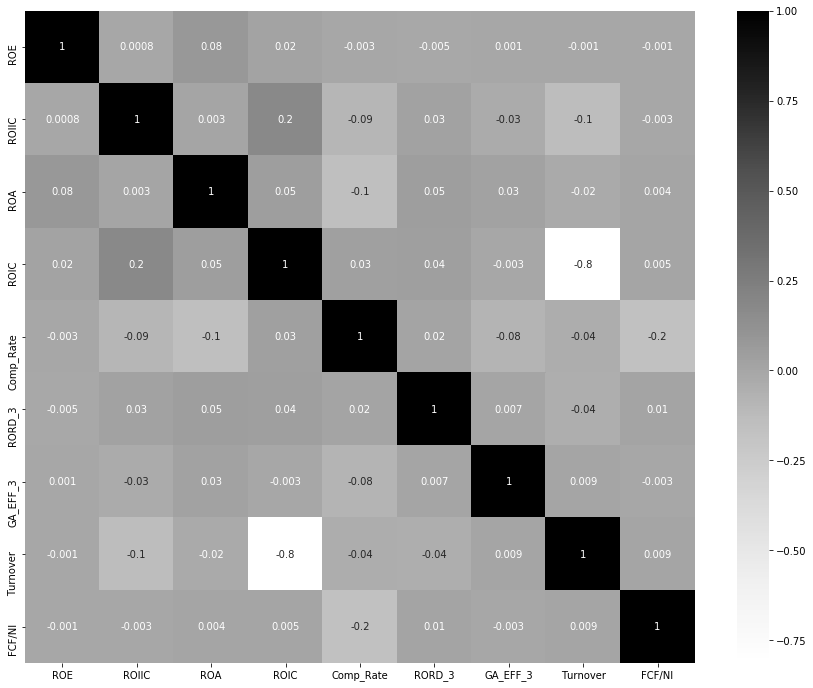

In [515]:
#select columns
#set plot size
#call heatmap and set parameters

Eff = stmt[['ROE', 'ROIIC', 'ROA', 'ROIC', 'Comp_Rate', 'RORD_3', 'GA_EFF_3', 'Turnover', 'FCF/NI']]
fig, ax = plt.subplots(figsize=(15,12)) 
sns.heatmap(Eff.corr(), annot = True, cmap = 'Greys', fmt = '.1g', ax = ax);

Looks like there's no correlation between these metrics, so we will keep all of them for use in our Power BI tool. For our clusters, we need to select the growth rate metrics and composition ratios we will use. We can also do this with a correlation matrix.

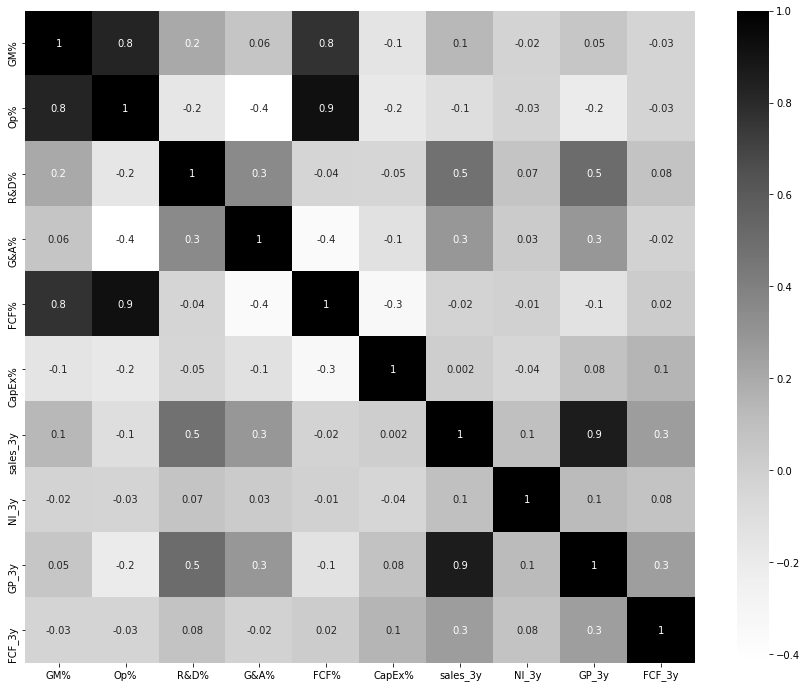

In [516]:
Comp = stmt[['GM%', 'Op%', 'R&D%', 'G&A%', 'FCF%', 'CapEx%', 'sales_3y', 'NI_3y', 'GP_3y', 'FCF_3y']]
fig, ax = plt.subplots(figsize=(15,12)) 
sns.heatmap(Comp.corr(), annot = True, cmap = 'Greys', fmt = '.1g', ax = ax);

Gross profit and sales growth have 90% correlation, so we'll leave in sales growth and take out gross profit for the purpose of our clustering algorithm. We'll also take out FCF growth and leave in FCF%. FCF growth is typically far more volatile than Net Income, making it more difficult to minimize within cluster variation (the cost function we will be using later for our KMeans).

Other interesting insights from this is the relatively strong correlation between Gross Margin % and FCF %. There is also a 50% correlation between companies who have a high R&D budget and 3 year sales growth. Both are potentially useful takeaways in the context of stock selection, as sales growth and FCF are very important inputs in landing on the instrinsic value of a business.

In [517]:
#set clustering features
#summarize features

clusters = stmt[['GM%', 'Op%', 'R&D%', 'G&A%', 'FCF%', 'CapEx%', 'sales_3y', 'NI_3y']].columns

stmt[clusters].describe()

,GM%,Op%,R&D%,G&A%,FCF%,CapEx%,sales_3y,NI_3y
count,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000
mean,0.473432,0.141992,0.048305,0.219804,0.082807,0.070848,0.101792,0.182388
std,0.402046,0.427582,0.106358,0.196222,0.391096,0.113769,0.188899,0.468305
min,-7.243103,-9.063761,0.000000,-0.040674,-8.146988,0.000000,-0.319015,-0.782833
25%,0.315888,0.089286,0.000000,0.081041,0.010418,0.014580,0.022178,0.014867
50%,0.456075,0.158576,0.000000,0.179569,0.098106,0.031649,0.063086,0.106596
75%,0.663021,0.242486,0.057836,0.298161,0.181359,0.066769,0.128781,0.225816
max,1.000000,1.000000,1.571459,1.820658,0.579361,0.982745,2.324885,4.656854


The summary above gives us an idea of the noise within each feature. KMeans is a very sensitive algorithm to outliers, so in the next few steps we will implement methods to contain them. Without dealing with outliers, we could end up with many clusters with just one company. To get more helpful groupings, we can cap the outliers at a certain percentile and then clip values beyond a certain number of standard deviations. Let's create an outliers function and replace function first, to deal with this.

We'll define outliers as values less the median greater than 1.5 times the interquartile range.

In [518]:
#define outliers function as values > 1.5*IQR

def outliers(x): 
       return np.abs(x- x.median()) > 1.5*(x.quantile(.75)-x.quantile(0.25))

In [519]:
#replace values with the 5th and 95th percentile min and max

def replace(x):
    out = x[outliers(x)]
    return x.replace(to_replace = [out.min(),out.max()], value = [np.percentile(x,5),np.percentile(x,95)])

In [520]:
#apply replace

stmt[['sales_3y', 'NI_3y']] = stmt[['sales_3y', 'NI_3y']].apply(replace, axis = 1)

We can still see many extraordinarily high values relative to the mean of each distribution. This is because many of these metrics may include values as inputs that the company does not prioritize. Take the PFCF multiple as an example: A large % of companies have almost no free cash flow but because their growth rates are high, the market values the company highly. We can contain these values by standardizing our data set and then clipping any values at a certain standard deviation level. By choosing 2.5 standard deviations, we can keep data within 99% of the distribution, chopping off unlikely values like the PFCF multiple we see now.

In [521]:
cols = stmt.select_dtypes('float', 'integer').columns

In [522]:
#apply lambda function for normalization

stmt_norm = stmt[cols].apply(lambda x: (x - x.mean())/x.std()).join(stmt['ticker'])

In [523]:
#use numpy clip at 2.5 stds

stmt_norm[clusters] = np.clip(stmt_norm[clusters], -2.5, 2.5)

With our data standardized and outliers accounted for, we can now plot the features we will be clustering on to get a sense of the relationships in our data.

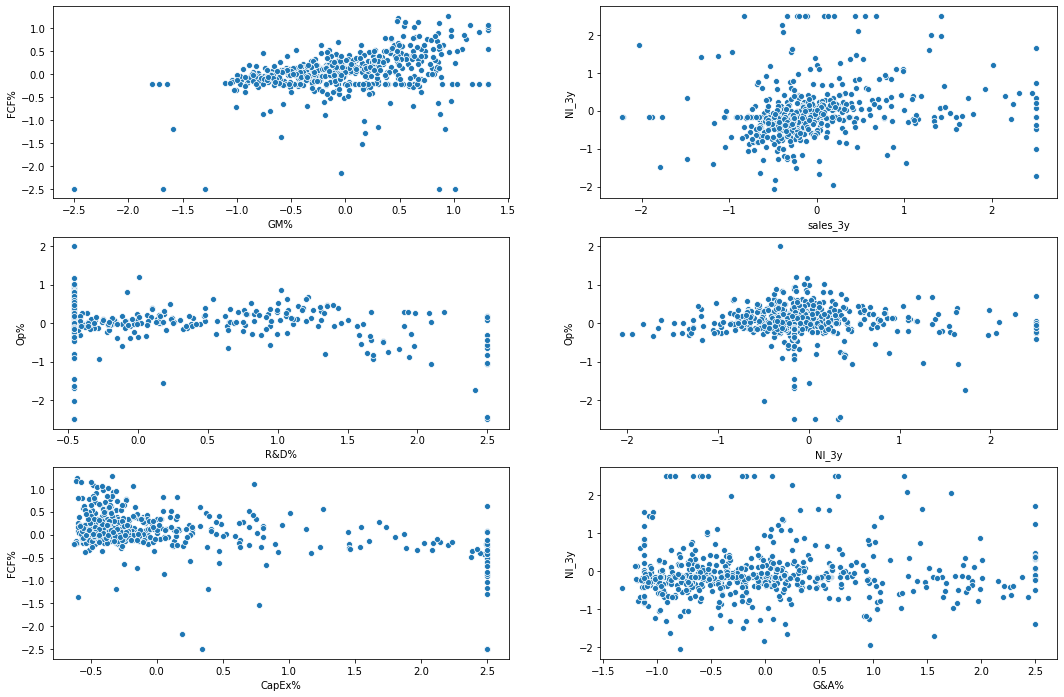

In [524]:
#set figsize and num of plots

fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (18, 12))
sns.scatterplot(x = 'GM%', y = 'FCF%', data = stmt_norm, ax = axs[0, 0], legend = 'brief');
sns.scatterplot(x = 'R&D%', y = 'Op%', data = stmt_norm, ax = axs[1, 0], legend = 'brief');
sns.scatterplot(x = 'CapEx%', y = 'FCF%', data = stmt_norm, ax = axs[2, 0], legend = 'brief');
sns.scatterplot(x = 'sales_3y', y = 'NI_3y', data = stmt_norm, ax = axs[0, 1], legend = 'brief');
sns.scatterplot(x = 'NI_3y', y = 'Op%', data = stmt_norm, ax = axs[1, 1], legend = 'brief');
sns.scatterplot(x = 'G&A%', y = 'NI_3y', data = stmt_norm, ax = axs[2, 1], legend = 'brief');

None of the plots above show very clear relationships, however given that we saw this in the correlation matrix too, we can probably say that a better gross margin % is related to better free cash flow conversion. 

It also looks as if lower capital expenditure businesses have better free cash flow conversion, which makes sense intuitively (Operating Cash Flow - CapEx = FCF). Let's start the modeling process and then we can chart more features using the clusters we develop to understand our data better.

## Modeling

We are finally at a point where we can apply the clustering algorithm to our data set. For this problem, we will be using the KMeans algorithm. Let's first walk through what the algorithm does, how we can optimize it, and then what we can hope to achieve before exporting the results to a CSV for Power BI to use.

As mentioned previously, KMeans is an unsupervised learning method (there are no labels) that is often used to better understand the structure and relationships within a data set. The K in the algorithm is the number of clusters we want to find in our data, which we choose beforehand. The 'Means' comes from the fact that we want to find the mean of all data points in a cluster, also known as the centroid. After choosing a K, the algorithm assigns each point to a cluster and then updates each center by replacing it with the mean of the points in the center. This step is repeated until the centers stop moving.

To optimize a KMeans algorithm, we must choose a cost function that helps us pick the number of clusters that minimizes variation within the clusters. This is known as the 'Within Cluster Sum of Squares' or inertia. By minimizing inertia, we can get clusters with observations that naturally profile closer to one another. In our next step, we will test a range of 1-30 clusters. What we hope to achieve is a number of clusters that keep variance low, while remaining interpretable (meaning less clusters is better). While the [elbow method](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/), is a popular way of choosing the optimal number of clusters, we will try to balance inertia and interpretability. In the conclusion of this exercise, we will be labeling each cluster for the Power BI tool. This will make each cluster easier to understand for users.

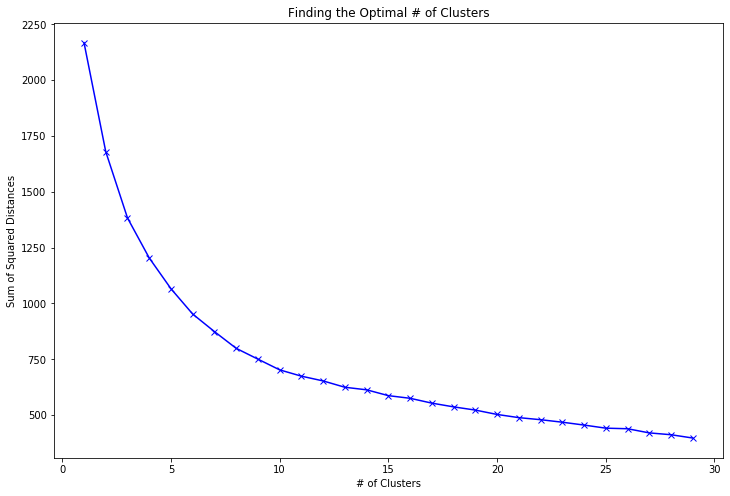

In [525]:
#initial empty list
#set range from 1-30
#fit KMeans on chosen features
#append result from cost function to list

from sklearn.cluster import KMeans


ssd = []
n_clusters = range(1, 30)

for n in n_clusters:
    k_means = KMeans(n_clusters = n)
    X = stmt_norm[clusters]
    model = k_means.fit(X)
    ssd.append(k_means.inertia_)

plt.figure(1, figsize = (12, 8))
plt.plot(n_clusters, ssd, 'bx-')
plt.xlabel('# of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Finding the Optimal # of Clusters')
plt.show()

The reduction in inertia begins to slow down considerably as the number of clusters reaches around 10. It's difficult to use the elbow method here because there is no steep drop at any point. We'll go forward with 11 clusters since the SSD begins to plateau around this point. Additionally, any clusters beyond this amount may over complicate the tool for users. In the next step, we'll set our clusters to 11 and then make a prediction for each observation of our data set.

In [526]:
#set to 11 clusters
#fit and predict

n_clusters = 11

kmeans = KMeans(n_clusters = n_clusters, random_state = 0)
kmeans.fit(X)
stmt_norm['cluster'] = kmeans.predict(X)
stmt_norm.head()

,GM%,R&D%,G&A%,Op%,CapEx%,FCF%,sales_3y,sales_2y,sales_1y,GP_3y,...,ROIIC,Rvst_Rate,Comp_Rate,mktCap,PE,PFCF,PS,PGP,ticker,cluster
0,-0.633833,-0.454178,-0.756220,-0.172980,-0.068247,-0.199314,-0.451167,-0.648673,-0.819610,-1.032914,...,0.232001,-0.093735,-0.254547,0.329749,0.497901,1.400660,-0.120937,0.159582,SBUX,0
1,0.578210,1.071725,0.122600,0.346502,-0.104233,0.395925,0.196744,0.305433,-0.010769,0.161240,...,0.158844,-0.015715,0.072374,0.043519,0.234722,0.089280,0.969402,0.216204,ILMN,2
2,-0.036353,0.718123,-0.773923,0.290466,-0.444889,0.277829,-0.124842,-0.787240,-0.114206,-0.102304,...,-0.387847,-0.029100,-0.197846,0.033357,0.049072,0.022874,0.014421,0.074594,LRCX,2
3,0.793401,-0.454178,-0.419117,0.312735,0.155220,0.127355,-0.177680,-0.267866,-0.297267,-0.170939,...,-5.313470,-0.048168,-0.316801,0.149508,0.058555,0.040175,-0.018484,0.001389,LVS,7
4,0.508344,0.812622,-0.239690,0.533962,0.326273,0.596992,0.201434,0.327753,0.327123,0.284853,...,1.371267,-0.046421,0.068467,9.795185,0.083238,0.024684,0.371884,0.100014,MSFT,2


Time to deconstruct our results a bit. Let's first look at the count of observations by cluster.

In [527]:
stmt = stmt.join(stmt_norm['cluster'])
stmt[['cluster', 'ticker']].groupby(['cluster']).count()

,ticker
cluster,
0,159
1,117
2,49
3,51
4,25
5,22
6,33
7,45
8,39


Notice the distribution of observations in our clusters. Specifically, cluster 9 only has 4 companies. This is not shocking, as there were likely to be a few companies that really did not fit in with any other group. We will just have to spot check this cluster in comparison to other clusters to see how it differs. Let's start breaking down our clusters by some of our metrics, starting with sales growth.

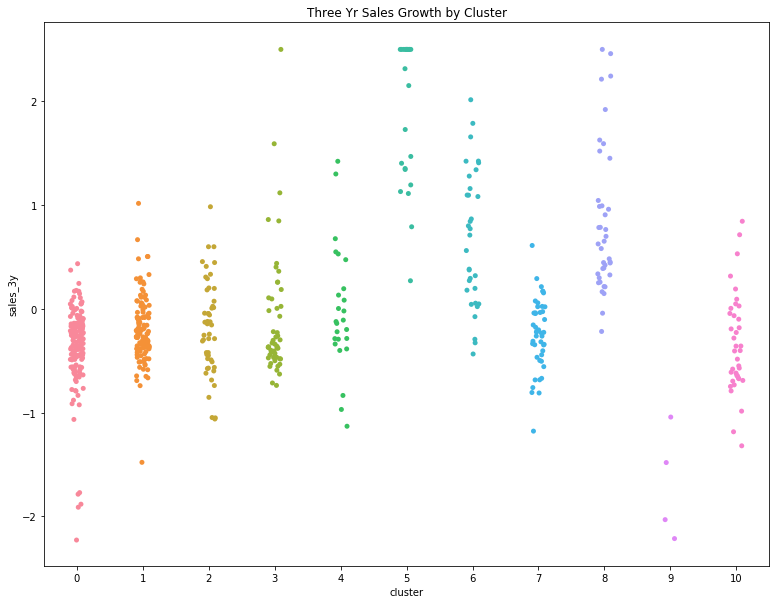

In [528]:
plt.figure(figsize = (13, 10))
plt.title('Three Yr Sales Growth by Cluster')
sns.stripplot(x = 'cluster', y = 'sales_3y', data = stmt_norm, jitter = 0.1);

For each plot, it might be useful to keep notes of the takeaways so that we can effectively label clusters later. Here are the takeaways from the strip plot above on sales growth:

- Cluster 9 shows four mostly declining companies
- Clusters 5 & 8 stand apart as the faster growth clusters
- Most companies in clusters 1, 2, 7, and 10 sit right around the mean for sales growth

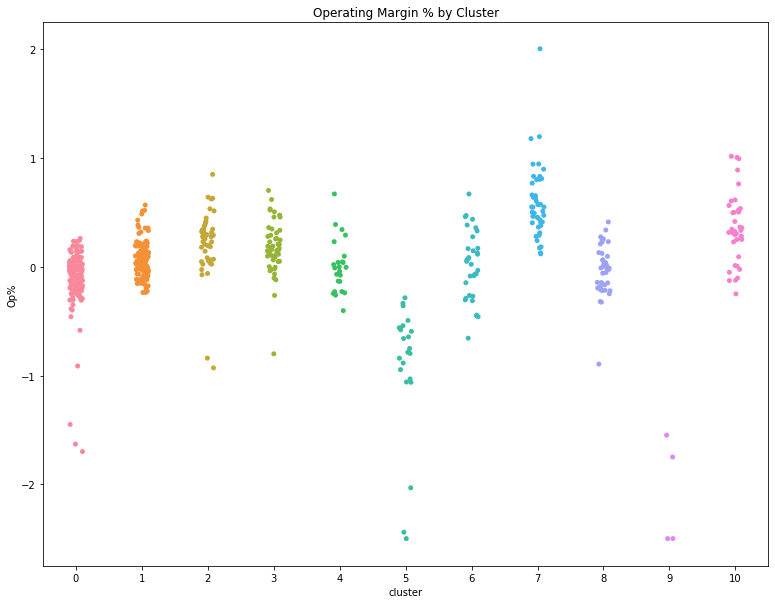

In [529]:
plt.figure(figsize = (13, 10))
plt.title('Operating Margin % by Cluster')
sns.stripplot(x = 'cluster', y = 'Op%', data = stmt_norm, jitter = 0.1);

The strip plot above gives us a sense of each cluster's profitability. Here are the takeaways:

- Cluster 7 is the highest profitability cluster
- Cluster 5 mostly sits below average on profitability
- Cluster 9 is among the worst in profitability as well

In the four plots below, we'll look at the most important efficiency metrics by cluster.

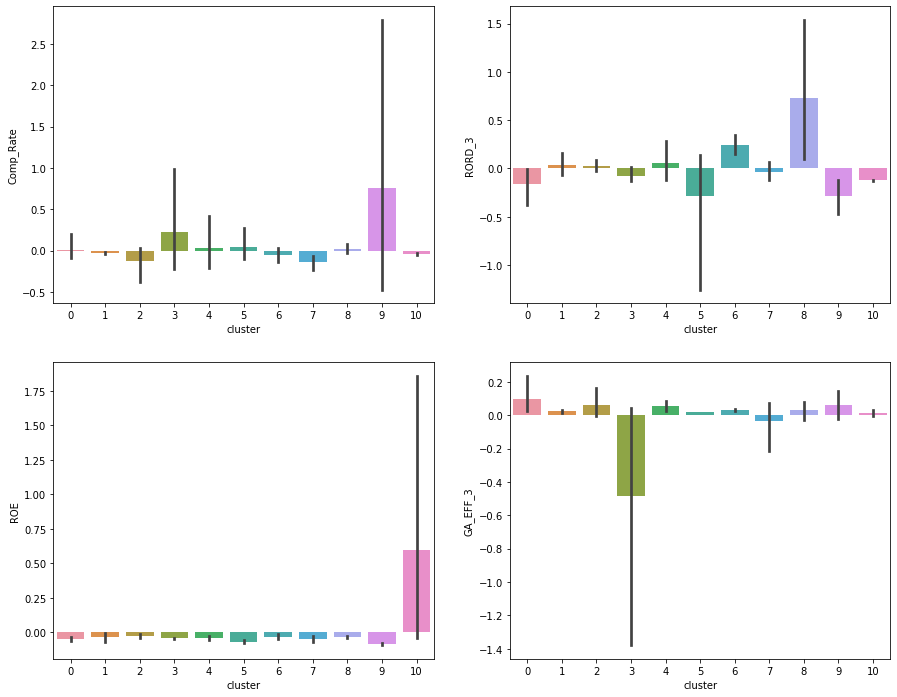

In [530]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 12))
sns.barplot(x = 'cluster', y = 'Comp_Rate', data = stmt_norm, ax = axs[0, 0]);
sns.barplot(x = 'cluster', y = 'ROE', data = stmt_norm, ax = axs[1, 0]);
sns.barplot(x = 'cluster', y = 'RORD_3', data = stmt_norm, ax = axs[0, 1]);
sns.barplot(x = 'cluster', y = 'GA_EFF_3', data = stmt_norm, ax = axs[1, 1]);

- Cluster 10 produces by far the highest returns on equity
- Cluster 9 has a high compounding rate
- Cluster 8 shows high returns on R&D spend
- Cluster 3 shows relatively poor G&A efficiency

Next, we'll look at four metrics that give us more insight into the type of companies within each cluster. Is one cluster more capital intensive? Is one cluster prioritizing R&D spend? Let's find out.

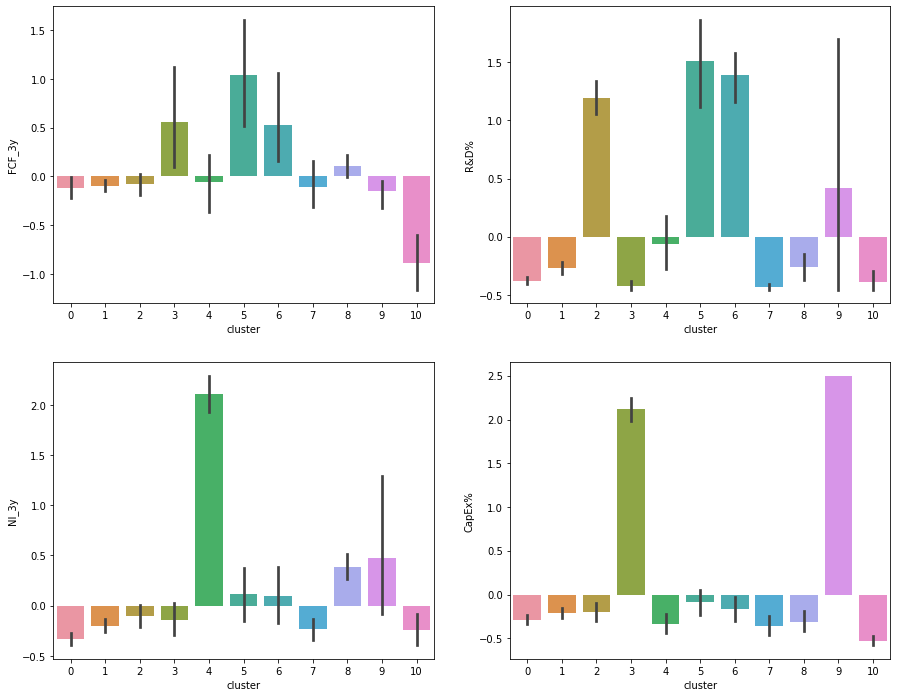

In [531]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 12))
sns.barplot(x = 'cluster', y = 'FCF_3y', data = stmt_norm, ax = axs[0, 0]);
sns.barplot(x = 'cluster', y = 'NI_3y', data = stmt_norm, ax = axs[1, 0]);
sns.barplot(x = 'cluster', y = 'R&D%', data = stmt_norm, ax = axs[0, 1]);
sns.barplot(x = 'cluster', y = 'CapEx%', data = stmt_norm, ax = axs[1, 1]);

- Cluster 10's FCF has shown decline
- Clusters 5 and 6 rely more heavily on R&D over CapEx
- Cluster 3 contains high capital intensity businesses
- Cluster 4 has been able to raise earnings the fastest

With those insights in hand, let's view every cluster in a single table and group them by their mean. Then, we can begin profiling each cluster accordingly and then exporting our results into a CSV.

In [532]:
stmt[['sales_3y', 'NI_3y', 'GM%', 'R&D%', 'G&A%', 
      'Op%', 'CapEx%', 'FCF%', 'cluster']].groupby('cluster').mean().sort_values(by = ['sales_3y', 'NI_3y', 
                                                                                       'GM%', 'R&D%', 'G&A%', 'Op%', 
                                                                                       'CapEx%', 'FCF%'], 
                                                                                ascending = False)

,sales_3y,NI_3y,GM%,R&D%,G&A%,Op%,CapEx%,FCF%
cluster,,,,,,,,
5,0.676659,0.237255,0.682962,0.275625,0.684618,-0.283073,0.060538,-0.117748
8,0.258605,0.364278,0.316368,0.020311,0.131731,0.128669,0.034731,0.086798
6,0.229874,0.228703,0.761655,0.210101,0.389876,0.148554,0.051535,0.232018
4,0.098972,1.783773,0.419811,0.041563,0.211947,0.139727,0.032209,0.114520
3,0.087290,0.122131,0.475942,0.002883,0.043560,0.216238,0.361432,-0.035910
2,0.067075,0.133925,0.615479,0.181307,0.176417,0.237316,0.047610,0.242041
1,0.064889,0.087431,0.504371,0.019519,0.284402,0.170241,0.046801,0.134337
7,0.055990,0.072166,0.692064,0.001992,0.096588,0.397646,0.029545,0.220745
10,0.036981,0.069591,0.931544,0.006874,0.552977,0.295515,0.009930,0.048583


As a sample, let's preview a cluster:

In [533]:
stmt[stmt['cluster'] == 5].sort_values('GP_3y', ascending = False).head(20)

,ticker,GM%,R&D%,G&A%,Op%,CapEx%,FCF%,sales_3y,sales_2y,sales_1y,...,Turnover,ROIIC,Rvst_Rate,Comp_Rate,mktCap,PE,PFCF,PS,PGP,cluster
124,FOLD,0.879481,1.571459,0.932088,-1.650269,0.109813,-1.483936,2.324885,1.221410,0.997227,...,0.377230,-0.808204,0.985397,-0.796402,3669.818909,-10.29,-13.57,20.14,22.89,5
547,NVTA,0.455305,0.472392,0.884685,-0.901773,0.092457,-0.761447,1.053264,0.782767,0.468013,...,0.436260,-0.211262,0.906338,-0.191475,7981.816154,-32.98,-48.34,36.81,80.84,5
182,PTON,0.458240,0.048743,0.420724,-0.011227,0.085656,0.120489,1.028970,1.048773,0.995519,...,0.000000,0.046611,1.240305,0.057812,32867.008874,-459.04,149.40,18.00,39.28,5
49,ZM,0.814672,0.107730,0.686552,0.020390,0.061164,0.182778,1.171408,1.027449,0.883891,...,0.000000,0.017782,2.071775,0.036841,34428.345485,1360.52,302.51,55.29,67.87,5
160,NVCR,0.748721,0.224876,0.525515,-0.001671,0.029845,0.045927,0.618339,0.408743,0.416211,...,1.849441,2.054032,0.734388,1.508456,12452.950275,-1722.27,771.74,35.45,47.34,5
548,CWBHF,0.534939,0.018542,0.778622,-0.262226,0.159133,-0.513024,0.858747,0.537672,0.361045,...,1.110936,-0.317467,0.823034,-0.261286,599.567070,-38.48,-12.34,6.34,11.84,5
48,SHOP,0.548510,0.217922,0.408752,-0.089437,0.035965,0.008780,0.594455,0.530988,0.470490,...,0.000000,-0.050988,0.691993,-0.035283,85202.744809,-682.48,6149.11,53.99,98.43,5
57,OKTA,0.728048,0.271556,0.767487,-0.310995,0.026349,0.068526,0.538916,0.511437,0.467905,...,0.811392,-0.108770,0.849897,-0.092444,24830.180143,-118.85,618.26,42.37,58.19,5
159,TDOC,0.666614,0.116832,0.612803,-0.133420,0.006344,0.047639,0.650070,0.540087,0.323996,...,0.588573,-0.029680,1.189640,-0.035309,25338.946373,-256.29,961.27,45.80,68.70,5
59,TWLO,0.536834,0.344968,0.503802,-0.312027,0.039991,-0.027608,0.599297,0.686160,0.745155,...,0.253007,-0.071080,0.865077,-0.061490,39804.894932,-129.63,-1270.88,35.09,65.36,5


The cluster above is the highest growth cluster. We'll want to keep these characteristics in mind as we label each cluster for our tool. With the clusters now defined, let's join them to the original data set. Then we can export our data set to a CSV for our Power BI tool to access.

In [534]:
#join cluster column
#change market cap to billions

fin_stmt = fin_stmt.join(stmt['cluster'])
fin_stmt['mktCap'] = (fin_stmt['mktCap']/1000).round(2)

In [535]:
fin_stmt.head()

,ticker,GM%,R&D%,G&A%,Op%,CapEx%,FCF%,sales_3y,sales_2y,sales_1y,...,Turnover,ROIIC,Rvst_Rate,Comp_Rate,mktCap,PE,PFCF,PS,PGP,cluster
0,SBUX,0.218603,0.000000,0.071418,0.068029,0.063084,0.004856,0.016567,-0.024605,-0.112816,...,9.140658,0.528327,-1.011821,-0.534572,115.22,124.12,1008.94,4.90,22.41,0
1,ILMN,0.705899,0.162292,0.243861,0.290150,0.058990,0.237652,0.138957,0.134649,0.063006,...,0.954472,0.376884,0.829425,0.312597,69.03,68.89,81.98,19.48,27.60,2
2,LRCX,0.458817,0.124683,0.067944,0.266189,0.020233,0.191465,0.078210,-0.047734,0.040522,...,1.925499,-0.754832,0.513544,-0.387640,67.39,29.93,35.04,6.71,14.62,2
3,LVS,0.792416,0.000000,0.137565,0.275711,0.088507,0.132615,0.068229,0.038957,0.000728,...,1.027292,-10.951456,0.063544,-0.695896,86.13,31.92,47.27,6.27,7.91,7
4,MSFT,0.677810,0.134734,0.172772,0.370304,0.107968,0.316289,0.139843,0.138374,0.136456,...,0.870419,2.886744,0.104780,0.302474,1642.88,37.10,36.32,11.49,16.95,2


We're ready to export and label each cluster.

In [536]:
#export

stmt.to_csv('inv_kmeans.csv')

## Conclusion

Using the table above, we can create easy to understand profiles for each of our clusters that we can deploy into our Power BI tool. Here's how each cluster was defined:

- **Cluster 0 - Low Margin Grind:** These companies are in competitive industries without much room for error.
- **Cluster 1 - Steady Compounders:** These are steady businesses mostly in the mature phase of their company's life cycle.
- **Cluster 2 - R&D Heavy Compounders:** These companies have skill and/or proprietary based advantages over their competitors.
- **Cluster 3 - Capital Intensive Compounders:** A high % of these business's resources go towards CapEx, making them expensive to compete with.
- **Cluster 4 - Raising Prices:** No group has grown earnings faster. These companies are in the process of monetizing their customer base.
- **Cluster 5 - Venture Style Growth:** Fast growth and high margins allow these businesses to reinvest all of their earnings.
- **Cluster 6 - R&D Charged Growth:** These companies have skill and/or proprietary based advantages that allow them to take share and/or raise prices.
- **Cluster 7 - Efficient Compounders:** These are companies that have no issues making money. They spend little on CapEx, R&D, *and* G&A.
- **Cluster 8 - Taking Share:** These companies provide expensive and/or subsidized services to their customers, allowing them to grow faster than usual.
- **Cluster 9 - No Man's Land:** The oddball companies. There's no one else like 'em.
- **Cluster 10 - Taking Profits:** Many of these companies have either begun to show saturation or have saturated their respective markets.

## Improvements

As I think about the ways this tool could be improved, four main items come to mind. I have listed each of the items below to enhance the tool in the future:

- **# of employees:** Scrape a record of the number of employees at each company going back many years. This would be a more concrete way of understanding which companies are getting the most output from their employees on a revenue/profitability basis. This is especially helpful to evaluate fast growing companies.
- **More data:** Yahoo Finance only has data going back 4 years. More data will give us a better understanding of the metrics we used.
- **Including companies with less operating history:** In an effort to narrow our focus, the tool only allows companies with at least 4 years of operating history, which limits the types of companies in the analysis. A next step could be to think about how to best include companies with only a short history of financials.
- **Back test clusters:** We can use the clusters created here and back test them to see how each cluster performed in the market. A missing piece in the tool is being able to see the actual returns by stock. So while we have an understanding of what creates intrinsic value based on decades of research, building annualized returns into the tool so that investors can see them by both stocks and different clusters would be helpful.